## Comparison of GeOT, MSE, and Moran's I on synthetic data

In [2]:
import pandas as pd
from libpysal.weights import KNN
from scipy.stats import wasserstein_distance
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import json
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import spearmanr, norm, pearsonr
from scipy.spatial.distance import cdist
from esda.moran import Moran
from sklearn.preprocessing import StandardScaler
from libpysal.weights import Queen
import wasserstein
import geomloss
import torch

from geoemd.loss.partial_ot import PartialOT
from geoemd.loss.moransi import MoransiLoss

from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


plt.rcParams.update({"font.size":15})



### Set up synthetic data

**Notes**
* The variable `bike_station` is only called like that for interpretability and legacy reasons. The locations are sampled randomly and do not refer to actual stations.

In [3]:
real_label="real"
pred_label="predicted"

In [4]:
num = 200

#### Tune the random seed to get data that has a similar average value left and right

In [5]:
def get_random_data_real(num, return_matrix=False):
    bike_stations = pd.DataFrame()
    bike_stations["x"] = np.random.rand(num) * 100
    bike_stations["y"] = np.random.rand(num) * 100
    bike_stations[real_label] = np.random.normal(size=num, loc=10, scale=3)
    if return_matrix:
        dist_matrix = cdist(bike_stations[["x", "y"]], bike_stations[["x", "y"]])
        return bike_stations, dist_matrix
    return bike_stations

def tune_balance_random_data_real(num):
    min_diff = 10
    for i in [32]: # range(40):
        np.random.seed(i)
        bike_stations = get_random_data_real(num)
        # distinguish left and right
        bike_stations["category"] = bike_stations["x"] > 50 # bike_stations["x"].median()
        real_per_cat = bike_stations.groupby(["category"]).agg({real_label: "mean"})
        diff = np.abs(real_per_cat.loc[True, "real"] - real_per_cat.loc[False, "real"])
        if diff < min_diff:
            min_seed = i
            min_diff = diff
#     print(min_diff)
    
    dist_matrix = cdist(bike_stations[["x", "y"]], bike_stations[["x", "y"]])
    return bike_stations, dist_matrix

In [6]:
bike_stations, dist_matrix = tune_balance_random_data_real(num)

### Experiment: Keep MAE stable but vary EMD

In [7]:
# Initialize objects to compute OT and Moran's I
ot_obj = PartialOT(dist_matrix, compute_exact=True, penalty_unb=0)
moransi_obj = MoransiLoss(dist_matrix)

In [8]:
from libpysal.weights import KNN
def morans_i_residuals(residual_df):
    morans_I = gpd.GeoDataFrame(residual_df, geometry = gpd.points_from_xy(x=residual_df["x"], y=residual_df["y"]))
    morans_I["residuals"] = morans_I["real"] - morans_I["predicted"]
    w = KNN.from_dataframe(morans_I)
    moran = Moran(morans_I["residuals"], w)
    return moran.I

In [9]:
scale_dict = {0: 2, 0.25: 1.95, 0.5: 1.9, 0.75: 1.8, 1: 1.6, 1.25: 1.3, 1.5: 1} 
all_res = []
for loc_diff in scale_dict.keys():
    for m in range(100):
        # Sample residuals from left and right side
        scale = scale_dict[loc_diff]
        vals_part1 = np.random.normal(size=bike_stations["category"].sum(), loc=loc_diff, scale=scale) # , loc=2, scale=2) # 
        vals_part2 = np.random.normal(size=(~bike_stations["category"]).sum(), loc=-loc_diff, scale=scale) # loc=4, scale=2), # 

        # add residuals to observation 
        new_vals_part1 = bike_stations.loc[bike_stations["category"], real_label] + vals_part1
        new_vals_part2 = bike_stations.loc[~bike_stations["category"], real_label] + vals_part2
        avg_diff = np.mean(new_vals_part1) - np.mean(new_vals_part2)

        # assign to the points in each part of the city
        bike_stations.loc[bike_stations["category"], pred_label] = new_vals_part1
        bike_stations.loc[~bike_stations["category"], pred_label] = new_vals_part2
        bike_stations[pred_label] = bike_stations[pred_label].clip(lower=0)

        # compute moran's I with library
        moransi = morans_i_residuals(bike_stations)
        
        # unnormed and normed vals
        pred_vals = bike_stations[pred_label].values
        gt_vals = bike_stations[real_label].values
        pred_vals_normed = pred_vals / np.sum(pred_vals)
        gt_vals_normed = gt_vals / np.sum(gt_vals) # TODO: change norming

        # compute metrics
        mae = np.mean(np.abs(pred_vals - gt_vals))
        mae_normed = np.mean(np.abs((pred_vals_normed - gt_vals_normed)))
        
        mse = np.mean((pred_vals - gt_vals)**2)

        emd = ot_obj(torch.from_numpy(pred_vals).unsqueeze(0), torch.from_numpy(gt_vals).unsqueeze(0))
    
        # compute moransI loss
        moransi_unnormalized = moransi_obj(
            torch.from_numpy(pred_vals).unsqueeze(0), torch.from_numpy(gt_vals).unsqueeze(0)
        ).item() # / ((pred_vals - gt_vals)**2).sum()

    #     print(mae, mae_normed, emd) # 1.1, 710 - 830
        all_res.append({"mode": loc_diff,
                       "mae": mae,
                        "mae_normed": mae_normed,
                        "MSE": mse,
                        "OT": emd,
                        "avg_diff": avg_diff,
                        "morans_i": moransi,
                        "morans_i_mine": moransi_unnormalized
                       })
all_res = pd.DataFrame(all_res)

### Analyze Moran's I

**NOTES**
* Moran's I is computed in 2 versions: 1) with the libpysal and Moran libraries (KNN weights) and 2) with an own implementation where the weights are set based on the cost matrix. The following cell shows that the correlation is high in both cases. In the paper, we report version 2.

In [10]:
from scipy.stats import pearsonr
pearsonr(all_res["morans_i_mine"], all_res["OT"]), pearsonr(all_res["morans_i"], all_res["OT"]) 

(PearsonRResult(statistic=0.9792049913803441, pvalue=0.0),
 PearsonRResult(statistic=0.929681882089524, pvalue=5.92116583665048e-305))

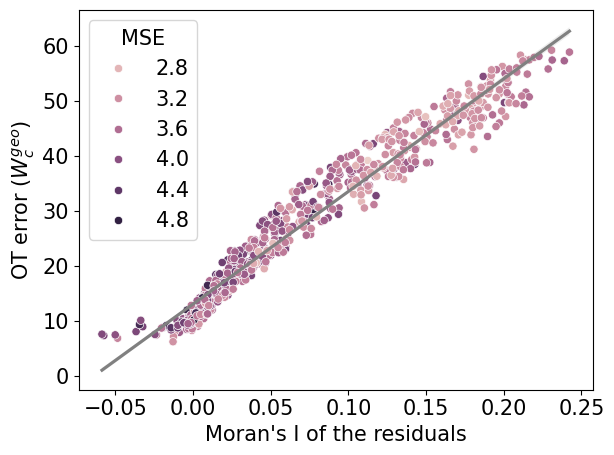

In [19]:
all_res.rename({"mae": "MAE"}, inplace=True, axis=1)
sns.scatterplot(data=all_res, x=all_res["morans_i_mine"], y=all_res["OT"], hue=all_res["MSE"])
sns.regplot(data=all_res, x=all_res["morans_i_mine"], y=all_res["OT"], color="grey", scatter_kws={"color":"lightblue", "alpha": 0})
plt.xlabel("Moran's I of the residuals")
plt.ylabel(r"OT error ($W^{geo}_c$)")
plt.tight_layout()
# plt.savefig("figures/ot_vs_moransi.pdf")
plt.show()

### Analyze relation between MAE and EMD

In [12]:
diff_per_mode = all_res.groupby("mode").agg({"avg_diff": "mean"}).to_dict()
all_res["diff"] = all_res["mode"].map(diff_per_mode["avg_diff"])

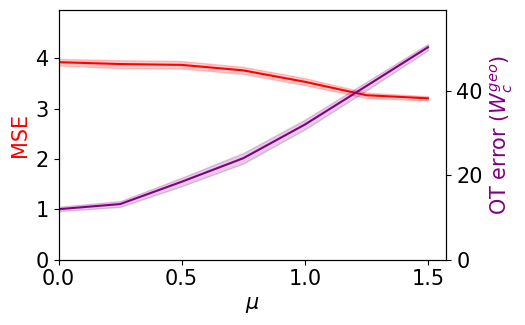

In [15]:
col_mse = "red"
col_ot = "purple"
fig, ax = plt.subplots(figsize=(5.5,3.5))
sns.lineplot(ax = ax, data=all_res, x = "mode", y="MSE", c=col_mse, errorbar=('ci', 95))
ax2 = ax.twinx()
sns.lineplot(ax = ax2, data=all_res, x = "mode", y="OT", c=col_ot,  errorbar=('ci', 95))
ax2.set_ylabel("OT error ($W^{geo}_c$)", c=col_ot)
ax.set_ylabel("MSE" , c=col_mse)
ax.set_ylim(0, all_res["MSE"].max() + 0.1)
ax2.set_ylim(0, all_res["OT"].max() + 0.05)
plt.xlim(0)
ax.set_xlabel(r"$\mu$") # "Avg. residuals right (x>50) - avg. residuals left")
plt.tight_layout()
# plt.savefig("figures/synthetic_comp.png")
plt.show()

### Synthetic plot

(just plotting the data distribution for figure 3)

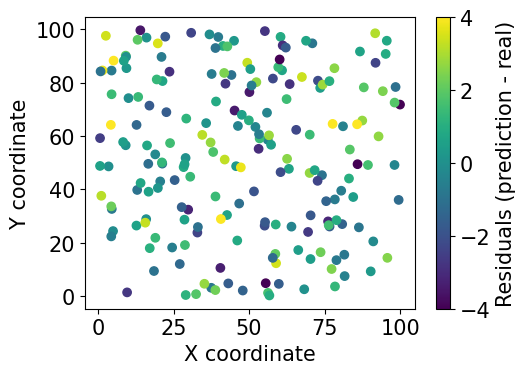

In [25]:
num = 200
loc_diff = 0

bike_stations, dist_matrix = tune_balance_random_data_real(num)
scale = scale_dict[loc_diff]
    # normal distributed in different directions
vals_part1 = np.random.normal(size=bike_stations["category"].sum(), loc=loc_diff, scale=scale) # , loc=2, scale=2) # 
vals_part2 = np.random.normal(size=(~bike_stations["category"]).sum(), loc=-loc_diff, scale=scale) # loc=4, scale=2), # 

# add to real values 
new_vals_part1 = bike_stations.loc[bike_stations["category"], real_label] + vals_part1
new_vals_part2 = bike_stations.loc[~bike_stations["category"], real_label] + vals_part2
avg_diff = np.mean(new_vals_part1) - np.mean(new_vals_part2)

# assign to the points in each part of the city
bike_stations.loc[bike_stations["category"], pred_label] = new_vals_part1
bike_stations.loc[~bike_stations["category"], pred_label] = new_vals_part2
bike_stations[pred_label] = bike_stations[pred_label].clip(lower=0)

        
plt.figure(figsize = (5.5,4))
plt.scatter(bike_stations["x"], bike_stations["y"], c=bike_stations[pred_label] - bike_stations[real_label],
           vmin=-4, vmax=4)
plt.colorbar(label="Residuals (prediction - real)")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.tight_layout()
# plt.savefig("figures/synthetic_example.pdf")
plt.show()